In [1]:
# Pandas is used for data manipulation
import pandas as pd
# Read in data and display first 5 rows
features = pd.read_csv('woody.csv')
features.head(5)

,dem,dist2canal,saltwater_max,groundwater_max,gw_duration,degradation
0,0.148050,67.082039,-0.469325,0.392048,0.840057,0
1,0.051878,84.852814,-0.373153,0.488220,0.840057,0
2,0.097211,94.868330,-0.418486,0.442887,0.840057,0
3,0.178980,318.904374,-0.495864,0.377907,0.908289,0
4,0.195100,296.984848,-0.511984,0.361787,0.908289,0


In [2]:
print('The shape of our features is:', features.shape)

The shape of our features is: (429317, 6)


In [3]:
features = pd.DataFrame(features)

In [4]:
features

,dem,dist2canal,saltwater_max,groundwater_max,gw_duration,degradation
0,0.148050,67.082039,-0.469325,0.392048,0.840057,0
1,0.051878,84.852814,-0.373153,0.488220,0.840057,0
2,0.097211,94.868330,-0.418486,0.442887,0.840057,0
3,0.178980,318.904374,-0.495864,0.377907,0.908289,0
4,0.195100,296.984848,-0.511984,0.361787,0.908289,0
...,...,...,...,...,...,...
429312,0.405030,3901.038323,-0.096618,0.005070,0.327381,0
429313,0.345530,3890.758281,-0.038905,0.021395,0.910163,0
429314,0.438530,3880.682930,-0.130857,-0.036934,0.773479,0
429315,0.657360,3861.152678,-0.349315,-0.100210,0.106261,0


In [5]:
features['degradation'].value_counts()

0    413913
1     15404
Name: degradation, dtype: int64

In [6]:
from sklearn.utils import resample

df_majority = features[features.degradation==0]
df_minority = features[features.degradation==1]

df_minority_upsampled = resample(df_minority,
                                 replace=True,     # sample with replacement
                                 n_samples=413913,   # to match majority class
                                 random_state=123) # reproducible results

df_upsampled = pd.concat([df_majority, df_minority_upsampled])

df_upsampled.degradation.value_counts()

0    413913
1    413913
Name: degradation, dtype: int64

In [7]:
# Use numpy to convert to arrays
import numpy as np
# Labels are the values we "want to predict
labels = np.array(df_upsampled['degradation'])
# Remove the labels from the features
# axis 1 refers to the columns
df_upsampled= df_upsampled.drop('degradation', axis = 1)
# Saving feature names for later use
feature_list = list(df_upsampled.columns)
# Convert to numpy array
features = np.array(df_upsampled)

In [8]:
features.shape

(827826, 5)

In [9]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [10]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (620869, 5)
Training Labels Shape: (620869,)
Testing Features Shape: (206957, 5)
Testing Labels Shape: (206957,)


In [12]:
# Import the model we are using
import sklearn.ensemble
clf = sklearn.ensemble.RandomForestRegressor(random_state=21)

In [13]:
param_grid = {'min_samples_split': [2, 5],
              'max_depth': [8, 16],
              'max_features': ['log2', 'sqrt'],
              'n_estimators': [1000,2000],
              'min_samples_leaf': [1, 2]}

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
gd_sr = GridSearchCV(estimator=clf,
                     param_grid=param_grid,
                     scoring='r2',
                     cv=KFold(n_splits=3, shuffle=True, random_state=21),
                     error_score="raise")

In [15]:
import warnings

warnings.filterwarnings('ignore')

gd_sr_res = gd_sr.fit(train_features, train_labels)

In [16]:
best_parameters = gd_sr.best_params_
print(best_parameters)

{'max_depth': 16, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 2000}


In [11]:
# Import the model we are using
import sklearn.ensemble
# Instantiate model with 1500 decision trees
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=2000, random_state=21, min_samples_split = 2,min_samples_leaf = 1, max_depth = 16, max_features = 'log2')
# Train the model on training data
clf = clf.fit(train_features, train_labels);

In [12]:
# Use the forest's predict method on the test data
predictions = clf.predict(test_features)
#Assess the accuracy using the validation dataset
print('Accuracy:',clf.score(test_features,test_labels))

Accuracy: 0.9825229395478288


In [13]:
from sklearn.metrics import roc_auc_score
prob_y = clf.predict_proba(test_features)
prob_y = [p[1] for p in prob_y]
print(roc_auc_score(test_labels, prob_y))

0.9986699212916011


In [14]:
# Get numerical feature importances
importances = list(clf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: saltwater_max        Importance: 0.32
Variable: dem                  Importance: 0.25
Variable: groundwater_max      Importance: 0.16
Variable: dist2canal           Importance: 0.15
Variable: gw_duration          Importance: 0.13


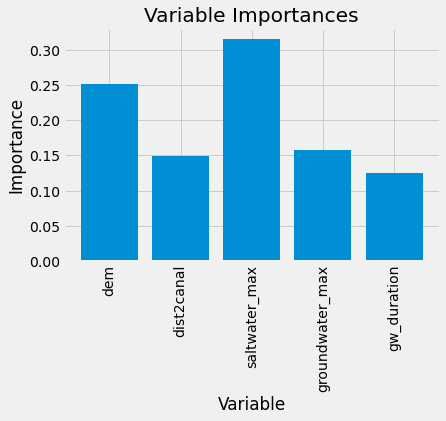

In [15]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');